In [1]:
import numpy as np
import pandas as pd
import nibabel as nib

from skimage.transform import resize
import skimage.morphology as morph

import matplotlib.pylab as plt

import glob as g

In [2]:
def matrix(fname):
    a = nib.load(fname)
    return np.asanyarray(a.dataobj)




In [3]:
def pad(A, sz):
    return np.pad(A, sz, 'edge')

def roller(A , x, y,z, sz = 1):
    return np.roll(np.roll( np.roll(pad(A, sz=sz), sz-x, axis = 0) , sz-y, axis = 1), sz-z, axis = 2)[sz:-sz, sz:-sz, sz:-sz]

def rolled(X, struct):
    struct = struct.astype('bool')
    a,b,c = struct.shape
    sz = (max(a,b)-1)//2
    Xm = []
    for i in range(a):
        for j in range(b):
            for k in range(c):
                if struct[i,j,k]:
                    Xm.append(roller(X, i, j, k, sz=sz).reshape(-1))
    return np.array(Xm)

In [4]:
F = sorted(g.glob("*/*hq_reg*nii.gz"))
print(F)

['ANTs/SL_hq_reg.nii.gz', 'ANTs/SL_hq_reg_gauss.nii.gz', 'ANTs/SL_hq_reg_lancz.nii.gz', 'ANTs/SL_hq_reg_splines.nii.gz', 'ANTs/t1w_hq_reg.nii.gz', 'ANTs/t1w_hq_reg_gauss.nii.gz', 'ANTs/t1w_hq_reg_lancz.nii.gz', 'ANTs/t1w_hq_reg_splines.nii.gz', 'ANTs/walnut_hq_reg.nii.gz', 'ANTs/walnut_hq_reg_gauss.nii.gz', 'ANTs/walnut_hq_reg_lancz.nii.gz', 'ANTs/walnut_hq_reg_splines.nii.gz', 'FSL/SL_hq_reg.nii.gz', 'FSL/SL_hq_reg_splines.nii.gz', 'FSL/t1w_hq_reg.nii.gz', 'FSL/t1w_hq_reg_splines.nii.gz', 'FSL/walnut_hq_reg.nii.gz', 'FSL/walnut_hq_reg_splines.nii.gz', 'frees/SL_hq_reg.nii.gz', 'frees/SL_hq_reg_splines.nii.gz', 'frees/t1w_hq_reg.nii.gz', 'frees/t1w_hq_reg_splines.nii.gz', 'frees/walnut_hq_reg.nii.gz', 'frees/walnut_hq_reg_splines.nii.gz']


In [5]:
const = {'reg': 1., 'gauss': 1./0.735, 'lancz': 1./0.87, 'splines': 4./3.}
support = {'reg': 3, 'gauss': 3, 'lancz': 5, 'splines': 3}


----------------------
ANTs_SL_reg


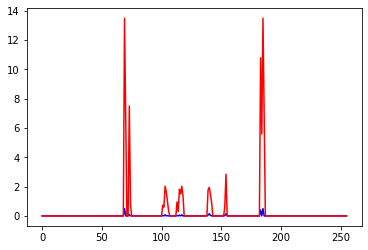

True

----------------------
ANTs_SL_gauss


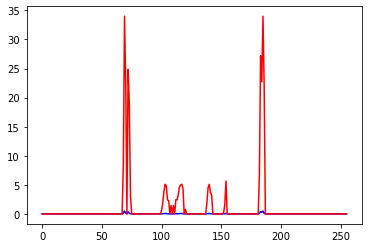

True

----------------------
ANTs_SL_lancz


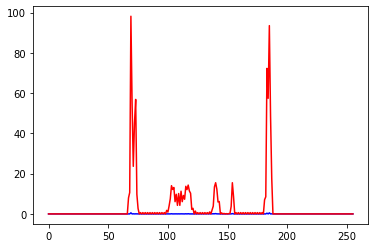

True

----------------------
ANTs_SL_splines


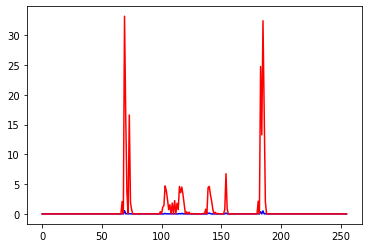

True

----------------------
FSL_SL_reg


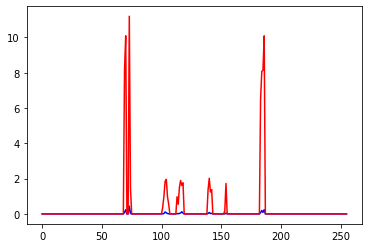

True

----------------------
FSL_SL_splines


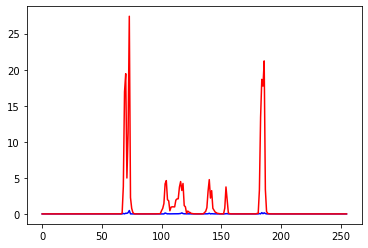

True

----------------------
frees_SL_reg


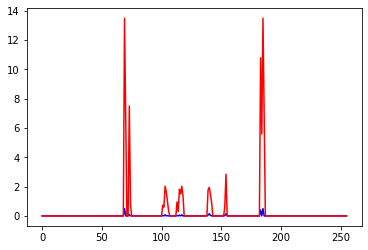

True

----------------------
frees_SL_splines


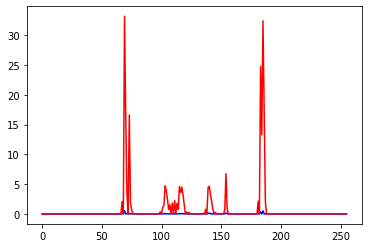

True


<Figure size 432x288 with 0 Axes>

In [6]:
DF = []
for f in F:
    softw = f.split("/")[0]
    img = f.split("/")[-1].split("_")[0]
    interp =  f.split("_")[-1].replace(".nii.gz","")
    
    
    if not img=='SL':
        continue
    
    name = softw + "_" + img + "_" + interp
    
    print('\n----------------------')
    print(name)
    
    A = matrix(f)
    B = matrix("data/" + img + "_hq.nii.gz")
    L = matrix("data/" + img + "_lq.nii.gz")
    
    Lx = resize(L, A.shape, order = 0)
    
    Err = np.abs(A-B)
    
    Fx = np.abs(A.reshape(-1) - rolled(Lx, morph.cube(support[interp])) )
    
    cost = const[interp] ** 3
    Bound = cost * np.sum( Fx , axis = 0).reshape(A.shape)
    
    m = np.min(A.shape)
    idx = np.arange(m)
    low = Err[idx,idx,idx]
    hig = Bound[idx,idx,idx]
    plt.plot( np.arange(len(low)), low, 'b', np.arange(len(hig)), hig, 'r') 
    plt.show()
    plt.savefig(f.replace('.nii.gz', '_bound_verify.png'))
    
    print(np.alltrue(Err <= Bound))
   